In [2]:
import sys
sys.path.append('..')
import torch 
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms 

import albumentations as A
from albumentations import Compose
from albumentations.pytorch.transforms import ToTensorV2
import pydicom as dicom
import pylidc as pl
from pylidc.utils import consensus
from statistics import median_high
import cv2

/work/hpc/dqm/Movies_Genre_Classification/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
lidc2_0 = "/work/hpc/pgl/LIDC-IDRI-Preprocessing/segment_data/Image/LIDC-IDRI-0002/0002_NI000_slice000.npy"
lidc2_1 = "/work/hpc/pgl/LIDC-IDRI-Preprocessing/segment_data/Image/LIDC-IDRI-0002/0002_NI000_slice001.npy"
lidc2_2 = "/work/hpc/pgl/LIDC-IDRI-Preprocessing/segment_data/Image/LIDC-IDRI-0002/0002_NI000_slice002.npy"
lidc2_3 = "/work/hpc/pgl/LIDC-IDRI-Preprocessing/segment_data/Image/LIDC-IDRI-0002/0002_NI000_slice003.npy"
lidc2_4 = "/work/hpc/pgl/LIDC-IDRI-Preprocessing/segment_data/Image/LIDC-IDRI-0002/0002_NI000_slice004.npy"
lidc2_5 = "/work/hpc/pgl/LIDC-IDRI-Preprocessing/segment_data/Image/LIDC-IDRI-0002/0002_NI000_slice005.npy"
lidc2_6 = "/work/hpc/pgl/LIDC-IDRI-Preprocessing/segment_data/Image/LIDC-IDRI-0002/0002_NI000_slice006.npy"
lidc2_14 = "/work/hpc/pgl/LIDC-IDRI-Preprocessing/segment_data/Image/LIDC-IDRI-0002/0002_NI000_slice014.npy"

resize = transforms.Resize([256, 256])

torch.Size([301, 306])
(256, 256)
2480.6511
-2000.0


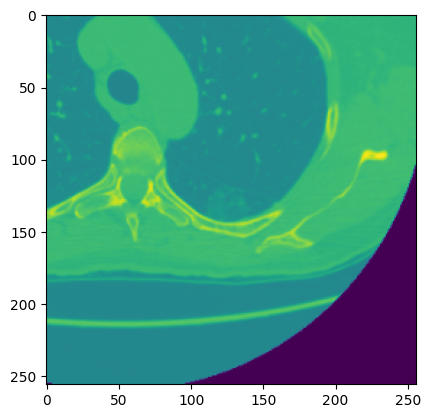

In [12]:
arr = np.load(lidc2_14)
arr = torch.from_numpy(arr).to(torch.float)
print(arr.shape)
arr = resize(arr.unsqueeze(0))
arr = arr.squeeze(0).numpy()
print(arr.shape)
print(arr.max())
print(arr.min())
plt.imshow(arr)

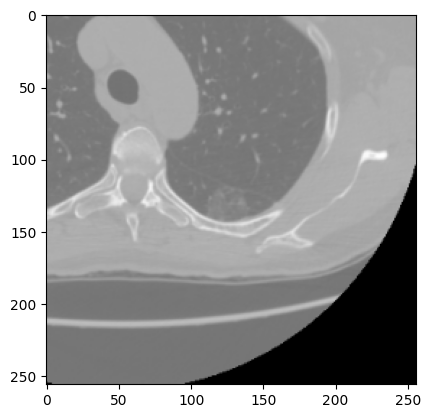

In [17]:
arr_rgb = ((arr - arr.min()) / (arr.max() - arr.min()) * 255).astype(np.uint8)
# Tạo ảnh từ mảng pixel sử dụng Pillow
image = Image.fromarray(arr_rgb)

image = image.convert("RGB")

# Hiển thị ảnh
plt.imshow(image)

In [14]:
def mask_overlay(image, mask, color=(0, 1, 0), p = 0.5):
    """Helper function to visualize mask on the top of the image."""
    mask = mask.squeeze()  # mask could be (1, 768, 768) or (768, 768)
    mask = np.dstack((mask, mask, mask)) * np.array(color, dtype=np.uint8)
    weighted_sum = cv2.addWeighted(mask, p, image, p, 0.0)
    img = image.copy()
    ind = mask[:, :, 1] > 0
    img[ind] = weighted_sum[ind]
    return img

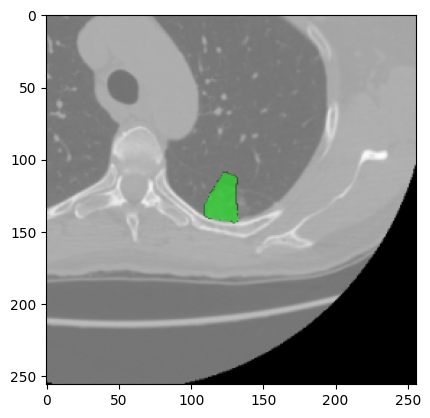

In [19]:
mask = np.load("/work/hpc/pgl/LIDC-IDRI-Preprocessing/segment_data/Mask/LIDC-IDRI-0002/0002_MA000_slice005.npy").astype(np.uint8) * 255

mask = torch.from_numpy(mask)
mask = resize(mask.unsqueeze(0))
mask = mask.squeeze(0).numpy()

overlay = mask_overlay(np.array(image), mask,(0, 1, 0), p = 0.5)
pil = Image.fromarray(overlay)

plt.imshow(overlay)

3


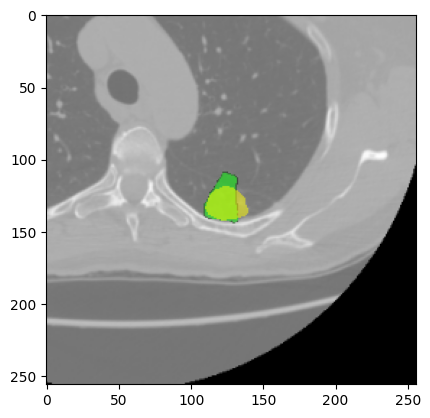

In [275]:
mask_pred = np.array(Image.open("/work/hpc/dqm/Lung-Nodule-Segmentation/images/prediction/LIDC-IDRI-2/14.png")).astype(np.uint8) 

overlay_pred = mask_overlay(overlay, mask_pred, (1, 1, 0), p = 0.5)
print(len(overlay_pred.shape))
plt.imshow(overlay_pred)


In [22]:
nodule_dir = "/work/hpc/pgl/LIDC-IDRI-Preprocessing/segment_data/Image"
image_nodule_list = []

for root, _, files in os.walk(nodule_dir):
    arr = []
    for file in files:
        if file.endswith(".npy"):
            dicom_path = os.path.join(root, file)
            mask_path = dicom_path.replace("Image", "Mask")
            mask_path = mask_path.replace("NI", "MA")
            arr.append(mask_path)
    image_nodule_list.append(arr)

In [13]:
dcom_path1 = '/work/hpc/pgl/LIDC-IDRI-Preprocessing/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-NA-NA-30178/3000566.000000-NA-03192/1-010.dcm'
dcom_path2 = '/work/hpc/pgl/LIDC-IDRI-Preprocessing/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-NA-NA-30178/3000566.000000-NA-03192/1-100.dcm'
dcom_path3 = '/work/hpc/pgl/LIDC-IDRI-Preprocessing/LIDC-IDRI/LIDC-IDRI-0007/01-01-2000-NA-NA-81781/3000631.000000-NA-57680/1-001.dcm'
dcom_path4 = '/work/hpc/pgl/LIDC-IDRI-Preprocessing/LIDC-IDRI/LIDC-IDRI-0007/01-01-2000-NA-NA-81781/3000631.000000-NA-57680/1-006.dcm'


[[-2048. -2048. -2048. ... -2048. -2048. -2048.]
 [-2048. -2048. -2048. ... -2048. -2048. -2048.]
 [-2048. -2048. -2048. ... -2048. -2048. -2048.]
 ...
 [-2048. -2048. -2048. ... -2048. -2048. -2048.]
 [-2048. -2048. -2048. ... -2048. -2048. -2048.]
 [-2048. -2048. -2048. ... -2048. -2048. -2048.]]
Max value: 3071.0
Min value: -2048.0


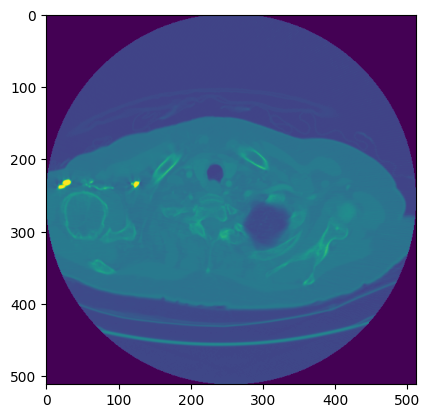

In [18]:
ds = dicom.dcmread(dcom_path1)
img = ds.pixel_array # dtype = uint16
img = img.astype(float)
img = img*ds.RescaleSlope + ds.RescaleIntercept
print(img)
print("Max value:", img.max())
print("Min value:", img.min())

plt.imshow(img)

<class 'numpy.ndarray'>
2
(512, 512)
int16
[[-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 ...
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]]
Max value: 4095
Min value: -1024


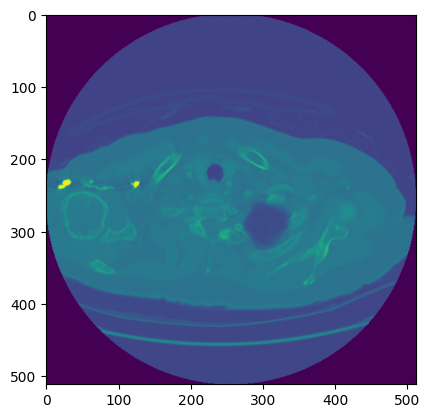

In [14]:
# Read Dcom files
ds = dicom.dcmread(dcom_path1)
ds_array = ds.pixel_array
print(type(ds.pixel_array))
print(len(ds_array.shape))

print(ds_array.shape)
print(ds_array.dtype)
print(ds_array)
print("Max value:", ds_array.max())
print("Min value:", ds_array.min())

plt.imshow(ds.pixel_array)
plt.show()

<class 'numpy.ndarray'>
(512, 512)
int16
[[-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 ...
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]]
Max value: 2265
Min value: -1024


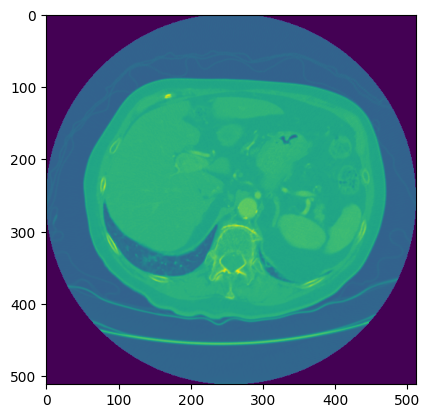

In [31]:
# Read Dcom files
ds = dicom.dcmread(dcom_path2)
ds_array = ds.pixel_array
print(type(ds.pixel_array))
print(ds_array.shape)
print(ds_array.dtype)
print(ds_array)
print("Max value:", ds_array.max())
print("Min value:", ds_array.min())

plt.imshow(ds.pixel_array)
plt.show()

<class 'numpy.ndarray'>
(512, 512)
int16
[[-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 ...
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]]
Max value: 4095
Min value: -1024


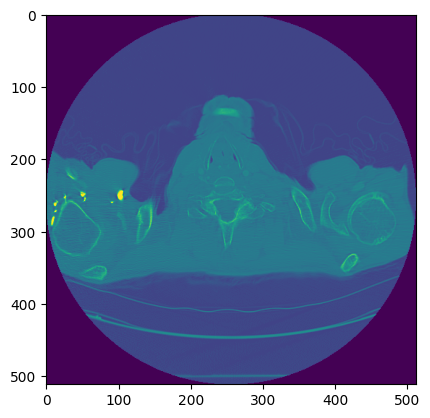

In [34]:
# Read Dcom files
ds = dicom.dcmread(dcom_path3)
ds_array = ds.pixel_array
print(type(ds.pixel_array))
print(ds_array.shape)
print(ds_array.dtype)
print(ds_array)
print("Max value:", ds_array.max())
print("Min value:", ds_array.min())

plt.imshow(ds.pixel_array)
plt.show()

<class 'numpy.ndarray'>
(512, 512)
int16
[[-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 ...
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]]
Max value: 4095
Min value: -1024


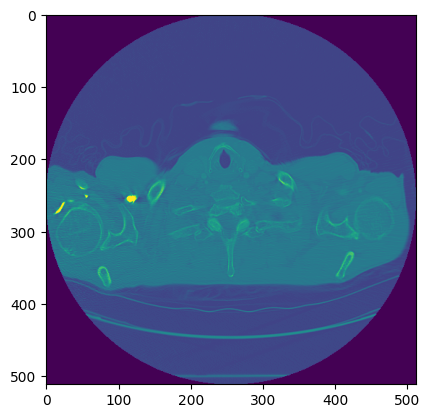

In [35]:
# Read Dcom files
ds = dicom.dcmread(dcom_path4)
ds_array = ds.pixel_array
print(type(ds.pixel_array))
print(ds_array.shape)
print(ds_array.dtype)
print(ds_array)
print("Max value:", ds_array.max())
print("Min value:", ds_array.min())

plt.imshow(ds.pixel_array)
plt.show()

In [5]:
print(ds_array[300][200])

148


In [ ]:
pid = 'LIDC-IDRI-0001'
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
nodules_annotation = scan.cluster_annotations()
vol = scan.to_volume()
print("Patient ID: {} Dicom Shape: {} Number of Annotated Nodules: {}".format(pid,vol.shape,len(nodules_annotation)))

In [10]:
LIDC_IDRI_list= [f for f in os.listdir('/work/hpc/pgl/LIDC-IDRI-Preprocessing/LIDC-IDRI') if not f.startswith('.')]
LIDC_IDRI_list.sort()
LIDC_IDRI_list

['LIDC-IDRI-0001',
 'LIDC-IDRI-0002',
 'LIDC-IDRI-0003',
 'LIDC-IDRI-0004',
 'LIDC-IDRI-0005',
 'LIDC-IDRI-0006',
 'LIDC-IDRI-0007',
 'LIDC-IDRI-0008',
 'LIDC-IDRI-0009',
 'LIDC-IDRI-0010',
 'LIDC-IDRI-0011',
 'LIDC-IDRI-0012',
 'LIDC-IDRI-0013',
 'LIDC-IDRI-0014',
 'LIDC-IDRI-0015',
 'LIDC-IDRI-0016',
 'LIDC-IDRI-0017',
 'LIDC-IDRI-0018',
 'LIDC-IDRI-0019',
 'LIDC-IDRI-0020',
 'LIDC-IDRI-0021',
 'LIDC-IDRI-0022',
 'LIDC-IDRI-0023',
 'LIDC-IDRI-0024',
 'LIDC-IDRI-0025',
 'LIDC-IDRI-0026',
 'LIDC-IDRI-0027',
 'LIDC-IDRI-0028',
 'LIDC-IDRI-0029',
 'LIDC-IDRI-0030',
 'LIDC-IDRI-0031',
 'LIDC-IDRI-0032',
 'LIDC-IDRI-0033',
 'LIDC-IDRI-0034',
 'LIDC-IDRI-0035',
 'LIDC-IDRI-0036',
 'LIDC-IDRI-0037',
 'LIDC-IDRI-0038',
 'LIDC-IDRI-0039',
 'LIDC-IDRI-0040',
 'LIDC-IDRI-0041',
 'LIDC-IDRI-0042',
 'LIDC-IDRI-0043',
 'LIDC-IDRI-0044',
 'LIDC-IDRI-0045',
 'LIDC-IDRI-0046',
 'LIDC-IDRI-0047',
 'LIDC-IDRI-0048',
 'LIDC-IDRI-0049',
 'LIDC-IDRI-0050',
 'LIDC-IDRI-0051',
 'LIDC-IDRI-0052',
 'LIDC-IDRI-

In [ ]:
from tqdm import tqdm
for patient in tqdm(LIDC_IDRI_list):
    pid = patient #LIDC-IDRI-0001~
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
    nodules_annotation = scan.cluster_annotations()
    vol = scan.to_volume()
    print("Patient ID: {} Dicom Shape: {} Number of Annotated Nodules: {}".format(pid,vol.shape,len(nodules_annotation)))

In [2]:
PATH = "/work/hpc/pgl/LIDC-IDRI-Preprocessing/LIDC-IDRI/LIDC-IDRI-0010/01-01-2000-NA-NA-43375/3000518.000000-NA-66796"

(512, 512)
<class 'numpy.ndarray'>
int16
[[-2000 -2000 -2000 ... -2000 -2000 -2000]
 [-2000 -2000 -2000 ... -2000 -2000 -2000]
 [-2000 -2000 -2000 ... -2000 -2000 -2000]
 ...
 [-2000 -2000 -2000 ... -2000 -2000 -2000]
 [-2000 -2000 -2000 ... -2000 -2000 -2000]
 [-2000 -2000 -2000 ... -2000 -2000 -2000]]
Max value: 4095
Min value: -2000


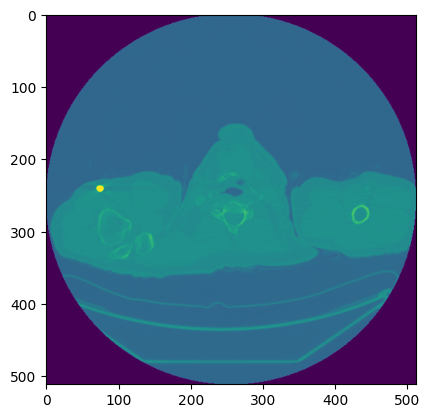

In [39]:
ds = dicom.dcmread("/work/hpc/pgl/LIDC-IDRI-Preprocessing/LIDC-IDRI/LIDC-IDRI-0010/01-01-2000-NA-NA-43375/3000518.000000-NA-66796/1-001.dcm")
print(ds.pixel_array.shape)
print(type(ds.pixel_array))
print(ds.pixel_array.dtype)

print(ds.pixel_array)
print("Max value:", ds.pixel_array.max())
print("Min value:", ds.pixel_array.min())


plt.imshow(ds.pixel_array)
plt.show()

In [12]:
array = []
for file in os.listdir(PATH):
    # print(x)
    if file.endswith(".dcm"):
        array.append(file)
        ds = dicom.dcmread(os.path.join(PATH, file))
        print(ds)
        
        print(ds.RescaleSlope, ' ', ds.RescaleIntercept)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.179012841093119025490608284954
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY', 'PROCESSED']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.

In [13]:
array

['1-002.dcm',
 '1-001.dcm',
 '1-003.dcm',
 '1-004.dcm',
 '1-005.dcm',
 '1-006.dcm',
 '1-007.dcm',
 '1-008.dcm',
 '1-009.dcm',
 '1-010.dcm',
 '1-011.dcm',
 '1-012.dcm',
 '1-013.dcm',
 '1-014.dcm',
 '1-015.dcm',
 '1-016.dcm',
 '1-017.dcm',
 '1-018.dcm',
 '1-019.dcm',
 '1-020.dcm',
 '1-021.dcm',
 '1-022.dcm',
 '1-023.dcm',
 '1-024.dcm',
 '1-025.dcm',
 '1-026.dcm',
 '1-027.dcm',
 '1-028.dcm',
 '1-029.dcm',
 '1-030.dcm',
 '1-031.dcm',
 '1-032.dcm',
 '1-033.dcm',
 '1-034.dcm',
 '1-035.dcm',
 '1-036.dcm',
 '1-037.dcm',
 '1-038.dcm',
 '1-039.dcm',
 '1-040.dcm',
 '1-041.dcm',
 '1-042.dcm',
 '1-043.dcm',
 '1-044.dcm',
 '1-045.dcm',
 '1-046.dcm',
 '1-047.dcm',
 '1-048.dcm',
 '1-049.dcm',
 '1-050.dcm',
 '1-051.dcm',
 '1-052.dcm',
 '1-053.dcm',
 '1-054.dcm',
 '1-055.dcm',
 '1-056.dcm',
 '1-057.dcm',
 '1-058.dcm',
 '1-059.dcm',
 '1-060.dcm',
 '1-061.dcm',
 '1-062.dcm',
 '1-063.dcm',
 '1-064.dcm',
 '1-065.dcm',
 '1-066.dcm',
 '1-067.dcm',
 '1-068.dcm',
 '1-069.dcm',
 '1-070.dcm',
 '1-071.dcm',
 '1-07

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [41]:
meta = pd.read_csv('/work/hpc/pgl/LIDC-IDRI-Preprocessing/meta_info.csv')
meta.head()


,patient_id,nodule_no,slice_no,original_image,mask_image,malignancy,is_cancer,is_clean
0,1,0,0,LIDC-IDRI-0001/0001_NI000_slice000,LIDC-IDRI-0001/0001_MA000_slice000,5,True,False
1,1,0,1,LIDC-IDRI-0001/0001_NI000_slice001,LIDC-IDRI-0001/0001_MA000_slice001,5,True,False
2,1,0,2,LIDC-IDRI-0001/0001_NI000_slice002,LIDC-IDRI-0001/0001_MA000_slice002,5,True,False
3,1,0,3,LIDC-IDRI-0001/0001_NI000_slice003,LIDC-IDRI-0001/0001_MA000_slice003,5,True,False
4,1,0,4,LIDC-IDRI-0001/0001_NI000_slice004,LIDC-IDRI-0001/0001_MA000_slice004,5,True,False


In [42]:
def is_nodule(row):
    if row[20:22] =='NI':
        return True
    else:
        return False

In [43]:
meta['is_nodule']= meta['original_image'].apply(lambda row: is_nodule(row))


In [44]:
# Lets separate Clean meta and meta data
clean_meta = meta[meta['is_nodule']==False]
clean_meta.reset_index(inplace=True)
meta = meta[meta['is_nodule']==True]
meta.reset_index(inplace=True)

In [46]:
clean_meta.head(5)


,index,patient_id,nodule_no,slice_no,original_image,mask_image,malignancy,is_cancer,is_clean,is_nodule
0,298,28,0,0,LIDC-IDRI-0028/0028_CN001_slice000,LIDC-IDRI-0028/0028_CM001_slice000,0,False,True,False
1,299,28,1,1,LIDC-IDRI-0028/0028_CN001_slice001,LIDC-IDRI-0028/0028_CM001_slice001,0,False,True,False
2,300,28,2,2,LIDC-IDRI-0028/0028_CN001_slice002,LIDC-IDRI-0028/0028_CM001_slice002,0,False,True,False
3,301,28,3,3,LIDC-IDRI-0028/0028_CN001_slice003,LIDC-IDRI-0028/0028_CM001_slice003,0,False,True,False
4,302,28,4,4,LIDC-IDRI-0028/0028_CN001_slice004,LIDC-IDRI-0028/0028_CM001_slice004,0,False,True,False


In [48]:
meta.head(5)


,index,patient_id,nodule_no,slice_no,original_image,mask_image,malignancy,is_cancer,is_clean,is_nodule
0,0,1,0,0,LIDC-IDRI-0001/0001_NI000_slice000,LIDC-IDRI-0001/0001_MA000_slice000,5,True,False,True
1,1,1,0,1,LIDC-IDRI-0001/0001_NI000_slice001,LIDC-IDRI-0001/0001_MA000_slice001,5,True,False,True
2,2,1,0,2,LIDC-IDRI-0001/0001_NI000_slice002,LIDC-IDRI-0001/0001_MA000_slice002,5,True,False,True
3,3,1,0,3,LIDC-IDRI-0001/0001_NI000_slice003,LIDC-IDRI-0001/0001_MA000_slice003,5,True,False,True
4,4,1,0,4,LIDC-IDRI-0001/0001_NI000_slice004,LIDC-IDRI-0001/0001_MA000_slice004,5,True,False,True


In [49]:
def is_train(row,train,val,test):
    if row in train:
        return 'Train'
    elif row in val:
        return 'Validation'
    else:
        return 'Test'

In [50]:

clean_patient_id = list(np.unique(clean_meta['patient_id']))
meta_patient_id = list(np.unique(meta['patient_id']))

In [51]:
def create_label_segmentation(meta):
    patient_id = list(np.unique(meta['patient_id']))
    train_patient , test_patient = train_test_split(patient_id,test_size= 0.2)
    train_patient, val_patient = train_test_split(train_patient,test_size= 0.25)
    print(len(train_patient),len(val_patient),len(test_patient))
    
    meta['data_split']= meta['patient_id'].apply(lambda row : is_train(row,train_patient,val_patient,test_patient))
    
    return meta

In [52]:
# We need to train/test split independently for clean_meta, meta
meta = create_label_segmentation(meta)
clean_meta = create_label_segmentation(clean_meta)

504 168 168
81 27 27


In [53]:
meta.head()


,index,patient_id,nodule_no,slice_no,original_image,mask_image,malignancy,is_cancer,is_clean,is_nodule,data_split
0,0,1,0,0,LIDC-IDRI-0001/0001_NI000_slice000,LIDC-IDRI-0001/0001_MA000_slice000,5,True,False,True,Train
1,1,1,0,1,LIDC-IDRI-0001/0001_NI000_slice001,LIDC-IDRI-0001/0001_MA000_slice001,5,True,False,True,Train
2,2,1,0,2,LIDC-IDRI-0001/0001_NI000_slice002,LIDC-IDRI-0001/0001_MA000_slice002,5,True,False,True,Train
3,3,1,0,3,LIDC-IDRI-0001/0001_NI000_slice003,LIDC-IDRI-0001/0001_MA000_slice003,5,True,False,True,Train
4,4,1,0,4,LIDC-IDRI-0001/0001_NI000_slice004,LIDC-IDRI-0001/0001_MA000_slice004,5,True,False,True,Train


In [55]:
# Clean Meta only stores meta information of patients without nodules.
clean_meta.head()


,index,patient_id,nodule_no,slice_no,original_image,mask_image,malignancy,is_cancer,is_clean,is_nodule,data_split
0,298,28,0,0,LIDC-IDRI-0028/0028_CN001_slice000,LIDC-IDRI-0028/0028_CM001_slice000,0,False,True,False,Test
1,299,28,1,1,LIDC-IDRI-0028/0028_CN001_slice001,LIDC-IDRI-0028/0028_CM001_slice001,0,False,True,False,Test
2,300,28,2,2,LIDC-IDRI-0028/0028_CN001_slice002,LIDC-IDRI-0028/0028_CM001_slice002,0,False,True,False,Test
3,301,28,3,3,LIDC-IDRI-0028/0028_CN001_slice003,LIDC-IDRI-0028/0028_CM001_slice003,0,False,True,False,Test
4,302,28,4,4,LIDC-IDRI-0028/0028_CN001_slice004,LIDC-IDRI-0028/0028_CM001_slice004,0,False,True,False,Test


In [ ]:
meta.to_csv('/work/hpc/dqm/Lung-Nodule-Segmentation/LUNG_DATA/meta_csv/meta.csv')
clean_meta.to_csv('/work/hpc/dqm/Lung-Nodule-Segmentation/LUNG_DATA/meta_csv/clean_meta.csv')